<h1>Data Generation</h1>
The purpose of this script is to generate more data for training. As we are building a model to forecast the volatility of next week's SPX, we have limited data for training. It is unrealistic to use old historical data because it does not represent today's market dynamics. In this script, I will be using a correlated merton jump diffusion model to model the closing prices of AAPL, AMZN, and MSFT. Simple noise will be added to model each asset's open, high and low prices. On top of that, the traded volume of each asset will be modeled by ACD stochastic model.



<h3>1.0 Importing packages, models, and dataset</h3>

- The following code chunks below will be importing packages such as pandas, numpy, scipy and matplotlib.
- a correlated merton jump diffusion model as well as an ACD model will be imported.



In [1]:
import pandas as pd
import numpy as np

from src.data_handling import (load_csv_data, 
                               filter_data_by_year_range, 
                               append_string_to_elements, 
                               save_to_csv)

from matplotlib import pyplot as plt

<h4>1.1 Data Loading and Preprocessing</h4>
We'll start by loading our dataset and taking a preliminary look at its structure.

In [2]:
DATA_PATH = "DATA/processed/df.csv"

df = load_csv_data(DATA_PATH)
df.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,...,VIX_Open,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,IRX_Open,IRX_High,IRX_Low,IRX_Close,IRX_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.531765,212818400.0,15.6290,15.7375,15.3480,15.4260,...,17.760000,20.139999,17.049999,17.790001,17.790001,0.030,0.030,0.015,0.015,0.015
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.840672,257142000.0,15.3505,15.4190,15.0425,15.1095,...,19.190001,21.290001,19.190001,19.920000,19.920000,0.008,0.018,0.003,0.003,0.003
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.842909,263188400.0,15.1120,15.1500,14.6190,14.7645,...,20.330000,22.900000,19.520000,21.120001,21.120001,0.023,0.023,0.018,0.020,0.020
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.177242,160423600.0,14.8750,15.0640,14.7665,14.9210,...,20.150000,20.719999,19.040001,19.309999,19.309999,0.023,0.025,0.020,0.020,0.020
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.106180,237458000.0,15.0160,15.1570,14.8055,15.0230,...,17.930000,18.090000,16.990000,17.010000,17.010000,0.020,0.020,0.015,0.018,0.018


<h4> 1.2 Filtering Data </h4>
We'll filter our data to focus on the years between 2015 and 2025.

In [3]:
MODELING_YEARS = (2015, 2025)

df = filter_data_by_year_range(df, *MODELING_YEARS)
df.head()

,AAPL_Open,AAPL_High,AAPL_Low,AAPL_Close,AAPL_Adj Close,AAPL_Volume,AMZN_Open,AMZN_High,AMZN_Low,AMZN_Close,...,VIX_High,VIX_Low,VIX_Close,VIX_Adj Close,IRX_Open,IRX_High,IRX_Low,IRX_Close,IRX_Adj Close,Year
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.531765,212818400.0,15.6290,15.7375,15.3480,15.4260,...,20.139999,17.049999,17.790001,17.790001,0.030,0.030,0.015,0.015,0.015,2015
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.840672,257142000.0,15.3505,15.4190,15.0425,15.1095,...,21.290001,19.190001,19.920000,19.920000,0.008,0.018,0.003,0.003,0.003,2015
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.842909,263188400.0,15.1120,15.1500,14.6190,14.7645,...,22.900000,19.520000,21.120001,21.120001,0.023,0.023,0.018,0.020,0.020,2015
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.177242,160423600.0,14.8750,15.0640,14.7665,14.9210,...,20.719999,19.040001,19.309999,19.309999,0.023,0.025,0.020,0.020,0.020,2015
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.106180,237458000.0,15.0160,15.1570,14.8055,15.0230,...,18.090000,16.990000,17.010000,17.010000,0.020,0.020,0.015,0.018,0.018,2015


<h3> 2.0 Modeling with Correlated Jump Diffusion Model (JDM) </h3>

In this section, we leverage the "CorrelatedJDMSimulator" class to fit and simulate the daily market closing prices of AAPL, MSFT, and AMZN on an annual basis. Specifically, we will create distinct models for each year (e.g., one for 2015, another for 2016, and so on). This approach acknowledges the frequent shifts in market dynamics, ensuring that our models capture the unique market trends and nuances of each specific year. Modeling the entire dataset collectively might overlook these subtleties.

For each year, we will estimate the model parameters based on the asset's closing prices and then initialize a simulator with these parameters, providing an accurate representation of the market dynamics for that year.





<h4>2.1 Initializing Storage for Models</h4>
We'll import the required package and create a dictionary to store the JDM models for each year.



In [4]:
from src.stoch_modelling import CorrelatedJDMSimulator
from scipy.optimize import minimize

correlated_JDM_models = {}

<h4> 2.2 Estimating Parameters and Initializing Models </h4>
For each year in our dataset, we'll:

1. Filter out incomplete years.
2. Estimate the model parameters using the CorrelatedJDMSimulator.
3. Initialize a JDM simulator with the estimated parameters.
4. Store the initialized model in our dictionary.

In [5]:
ASSETS = ["AAPL", "MSFT", "AMZN"]

for year, df_year in df[append_string_to_elements(ASSETS, "_Close") + ["Year"]].groupby("Year"):
    # Remove "Year" column and skip incomplete years
    df_year = df_year.drop("Year", axis=1)
    if len(df_year) < 260:
        continue

    # initialise model
    corrJDMsim = CorrelatedJDMSimulator()

    # Estimate parameters
    corrJDMsim.estimate_parameters(df_year.values)

    # Save model into dictionary
    correlated_JDM_models[year] = corrJDMsim

c:\Users\bruce\Desktop\Imperial\Sem 3\AP\CODE\src\stoch_modelling.py:259: RuntimeWarning: overflow encountered in double_scalars
  drift_term = self.drifts[i] * prices[t-1, i] * self.dt
c:\Users\bruce\Desktop\Imperial\Sem 3\AP\CODE\src\stoch_modelling.py:264: RuntimeWarning: invalid value encountered in double_scalars
  prices[t, i] = prices[t-1, i] + drift_term + shock_term + jump
c:\Users\bruce\Desktop\Imperial\Sem 3\AP\CODE\src\stoch_modelling.py:289: RuntimeWarning: invalid value encountered in log
  log_returns = np.log(simulated_prices[1:] / simulated_prices[:-1])


<h4>2.3 Visualization </h4>

Now that we have our JDM, we can simulate the 2015 market dynamics of AAPL, MSFT, and AMZN's closing prices

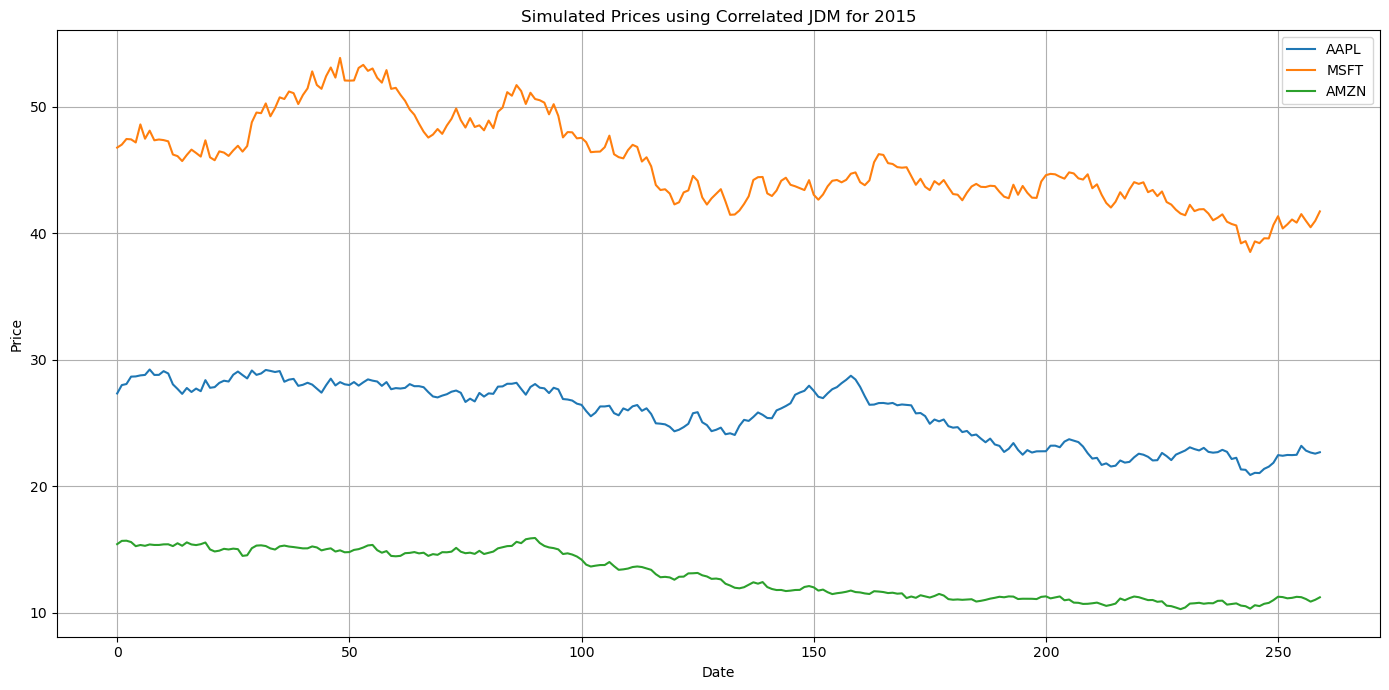

In [6]:
SIMULATION_DAYS = 260

simulated_data = correlated_JDM_models[2015].simulate(SIMULATION_DAYS)

plt.figure(figsize=(14, 7))  # Set the figure size

for i, asset in enumerate(ASSETS):  # Assuming 'assets' contains the names ['AAPL', 'MSFT', 'AMZN']
    plt.plot(np.arange(0, 260, 1), simulated_data[:, i], label=asset)

plt.title("Simulated Prices using Correlated JDM for 2015")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h3>3.0 Merton Jump Diffusion Model (Modelling VIX)</h3>


In this section, we will utilize the `JDMSimulator` (Merton and Kou model) to estimate parameters and simulate data for the VIX. The VIX, often termed the "fear index", represents the market's expectation of stock market volatility over the next 30 days.

<h4>3.1 Defining Constants </h4>

In [7]:
from src.stoch_modelling import JDMSimulator
MIN_DATA_POINTS = 260
MODEL = "Merton"

vix_models = {} # Initialising dictionary to save models

<h4>3.2 Estimating Parameters for VIX using the Jump Diffusion Model</h4>

In this section, we'll be estimating the parameters for the VIX (Volatility Index) using the Jump Diffusion Model.

For each year in our dataset, we'll:

- Filter out years with insufficient data points.
- Initialize the JDM.
- Estimate the model parameters using the VIX's closing prices for that year.
- Store the model for future simulations. 

In [8]:
# Grouping and modelling the data by year
for year, df_year in df.groupby("Year"):

    # Skip incomplete years
    if len(df_year) < MIN_DATA_POINTS: 
        continue

    # Initialise model
    model = JDMSimulator(model = MODEL)

    # Estimaste parameters
    estimated_params = model.estimate_parameters(df_year['VIX_Close'].values)
    
    # Save model for simulation later
    vix_models[year] = model

<h4>3.3 Visualisation </h4>

The below code chuck will be visualising the simulated price of VIX in 2015

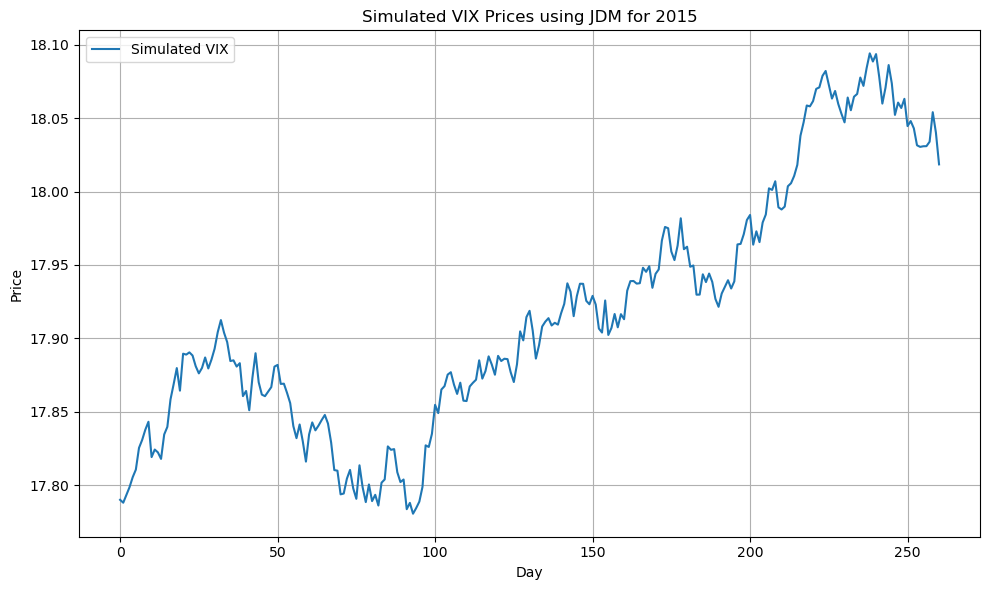

In [9]:
SIMULATION_DAYS = 260
vix_sim_data = vix_models[2015].simulate(SIMULATION_DAYS)

plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(vix_sim_data, label = "Simulated VIX")
plt.title("Simulated VIX Prices using JDM for 2015")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<h3> 4.0 Cox-Ingersoll-Ross(CIR) Model for IRX </h3>


In this notebook, we implement the `CIRJumpModel`, a combination of the Cox-Ingersoll-Ross (CIR) model and Merton's jump diffusion model. This model captures both the mean-reverting behavior of interest rates and potential sudden jumps due to unexpected market events. We'll be using historical interest rate data to estimate the model parameters for each year and then simulate the interest rates for the year 2015.


<h4> 4.1 Importing model and initialising dictionary </h4>

In [10]:
from src.stoch_modelling import CIRJumpModel

# Dictionary to store models for each year
irx_models = {}

<h4>4.2 Data Modeling by Year </h4>

For each year in our dataset, we perform the following steps:

1. **Filtering**: We exclude years with insufficient data points. This ensures that our parameter estimation is based on a reasonably complete dataset.
2. **Model Initialization**: For each valid year, we initialize the `CIRJumpModel` using the interest rate data for that year.
3. **Parameter Estimation**: We estimate the model parameters using the historical data.
4. **Storing the Model**: Once the parameters are estimated, we store the model instance in a dictionary. This allows us to easily retrieve and use the model for simulations later.


In [11]:
# Grouping and modelling the data by year
for year, df_year in df.groupby("Year"):

    # Skip incomplete years
    if len(df_year) < MIN_DATA_POINTS: 
        continue

    # Initialise model
    model = CIRJumpModel()

    # Estimate parameters
    model.estimate_parameters(df_year["IRX_Close"].values)
    
    # Save model for simulation later
    irx_models[year] = model

c:\Users\bruce\Desktop\Imperial\Sem 3\AP\CODE\src\stoch_modelling.py:192: RuntimeWarning: divide by zero encountered in log
  likelihoods.append(np.log(likelihood))
c:\Users\bruce\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
c:\Users\bruce\Desktop\Imperial\Sem 3\AP\CODE\src\stoch_modelling.py:190: RuntimeWarning: invalid value encountered in sqrt
  sigma_t = sigma * np.sqrt(rates[t-1] * dt)


<h4>4.3 Visualization of Simulated Data for 2015 </h4>

After modeling the data and estimating the parameters for each year, we can use the model to simulate interest rate behavior. In this section, we'll visualize the simulated interest rates for the year 2015. This provides an insight into how the model perceives potential future interest rate movements based on historical data.


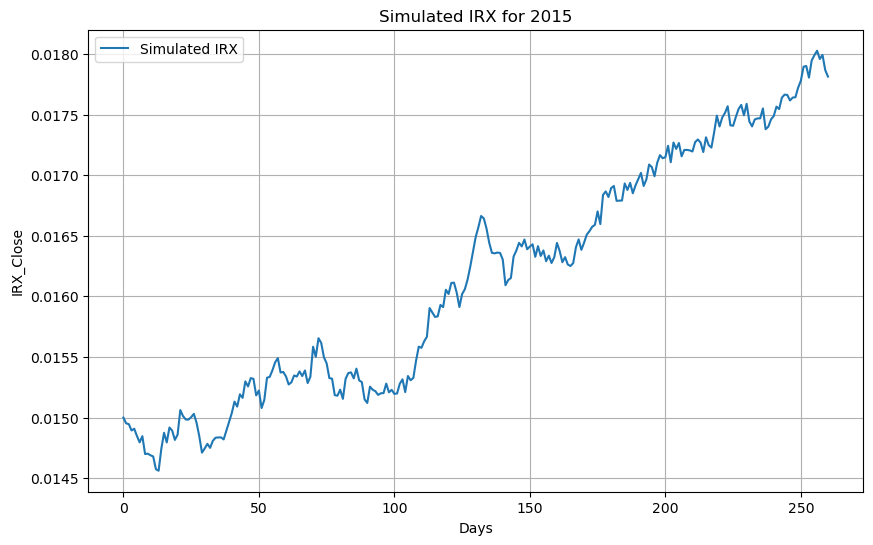

In [12]:
# Visualize a simulation from 2015
simulated_irx_2015 = irx_models[2015].simulate(260)
plt.figure(figsize=(10,6))
plt.plot(simulated_irx_2015, label="Simulated IRX")
plt.title("Simulated IRX for 2015")
plt.xlabel("Days")
plt.ylabel("IRX_Close")
plt.legend()
plt.grid(True)
plt.show()


<h3> 4.0 SPX Linear Factor Models </h3>

The S&P 500 (SPX) is a market-capitalization-weighted index of 500 of the largest publicly traded companies in the U.S. Given that companies like AAPL, MSFT, and AMZN have significant market capitalizations, their stock price movements can have a noticeable impact on the SPX. Instead of modeling SPX as a standalone stochastic process, we use a linear factor model. This approach assumes that the price of SPX is linearly dependent on these major assets. By doing so, we can capture the influence of these assets on the SPX and provide a more accurate representation of its behavior.

The Linear Factor Model (LFM) is commonly used in finance to describe the returns of an asset as a linear combination of various factors. The matrix form of the equation is particularly useful when dealing with multiple assets and factors.

Given:

- $r$ : Vector of SPX price (dimension $N \times 1$, where $N$ is the number of assets).
- $F$ : Matrix of factor returns (dimension $T \times K$, where $T$ is the number of time periods and $K$ is the number of factors).
- $B$ : Matrix of factor loadings or betas (dimension $N \times K$).
- $\alpha$ : Vector of asset-specific expected returns (dimension $N \times 1$).
- $\epsilon$ : Matrix of idiosyncratic (or asset-specific) returns (dimension $N \times T$).

The matrix form of the Linear Factor Model is:

$$ r = \alpha + B \times F^T + \epsilon$$

Where:

- $r$ : $N \times T$ matrix of returns for $ N $ assets over $ T $ time periods.
- $\alpha$ : $N \times T$ matrix where each row is the asset-specific expected return for the corresponding asset, repeated $T$ times.
- $B \times F^T$ : $N \times T$ matrix of returns due to the factors.
- $\epsilon$ : $N \times T$ matrix of idiosyncratic returns.


<h4>4.1 Importing Packages </h4>

The objective function and the implementation of the linear factor model is provided in the linear_factor_model.py package. "SPX_FACTORS" will be the factors that SPX will be calculated upon.

In [13]:
from src.linear_factor_model import LinearFactorModel

SPX_FACTORS = ["AAPL", "MSFT", "AMZN", "VIX", "IRX"]

spx_factors = df[append_string_to_elements(SPX_FACTORS, "_Close")].values

<h4>4.2 Parameter Optimization</h4>
Using the minimize function from scipy.optimize, we'll optimize the parameters of our linear factor model to minimize the mean squared error. This will be done for SPX and VIX

In [14]:
# Create an instance of the LinearFactorModel class
lfm = LinearFactorModel()

# Train the model
spx_params = lfm.fit(df["SPX_Close"].values, spx_factors)

# Display the results
print(f"SPX's Optimal Parameters:")
for i, param in enumerate(spx_params):
    if i == 0:
        print(f"alpha = {param:.4f}")
    else:
        print(f"beta{i} = {param:.4f}")

SPX's Optimal Parameters:
alpha = 1855.8279
beta1 = 3.2783
beta2 = 5.9490
beta3 = 3.1003
beta4 = -13.7081
beta5 = 14.3692


<h4>4.3 Visualization </h4>
Finally, we'll visualize the actual vs. predicted SPX values to see how well our model fits the data.

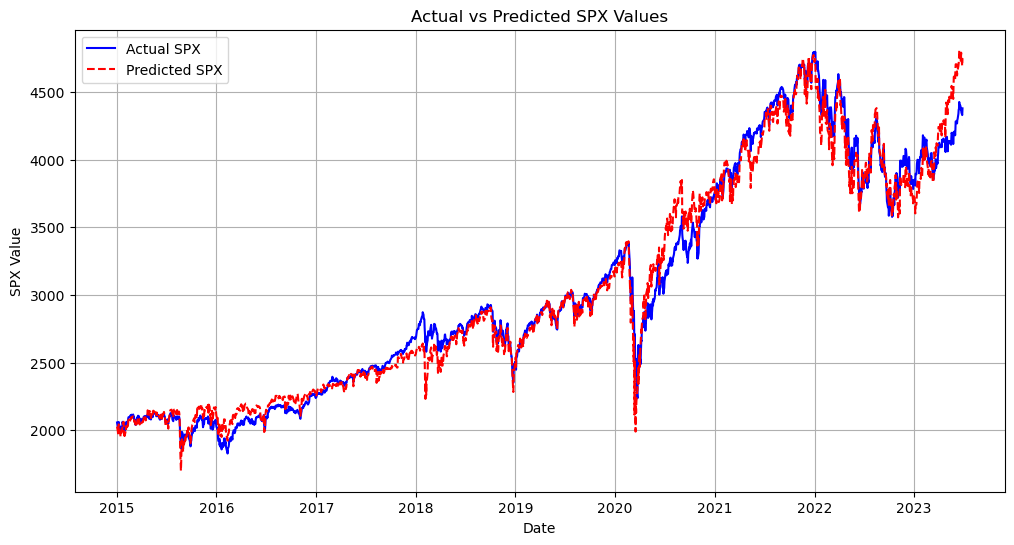

In [15]:
# Make predictions using the trained model
predicted_SPX = lfm.predict(spx_factors)

# Plotting the actual vs predicted SPX values
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['SPX_Close'], label='Actual SPX', color='blue')
plt.plot(df.index, predicted_SPX, label='Predicted SPX', color='red', linestyle='--')
plt.title('Actual vs Predicted SPX Values')
plt.xlabel('Date')
plt.ylabel('SPX Value')
plt.legend()
plt.grid(True)
plt.show()

<h3>5.0 KDE Models </h3>

In this notebook, we'll be using Kernel Density Estimation (KDE) to model the volume of various assets. We'll also model the difference in asset open, close, and high prices.


<h4>5.1 Import models and set constants </h4>
The code chunk below will be importing the require packages as well as setting the constant variables

In [16]:
from src.kde_modelling import fit_kde_model, generate_kde_models, plot_kde_subplot
from sklearn.neighbors import KernelDensity

BANDWIDTH = 0.5
MIN_DATA_POINTS = 260
KDE_MODEL_ASSETS = ["SPX", "AAPL", "MSFT", "AMZN", "VIX", "IRX"]

<h4>5.2 Generate KDE models </h4>

In [17]:
kde_models = generate_kde_models(df, KDE_MODEL_ASSETS,
                                 BANDWIDTH, MIN_DATA_POINTS)

<h4>5.1 Analysis and Visualization </h4>

Now that we have our KDE models, below is a code chunk visualises AAPL's KDE model relative to the actual data

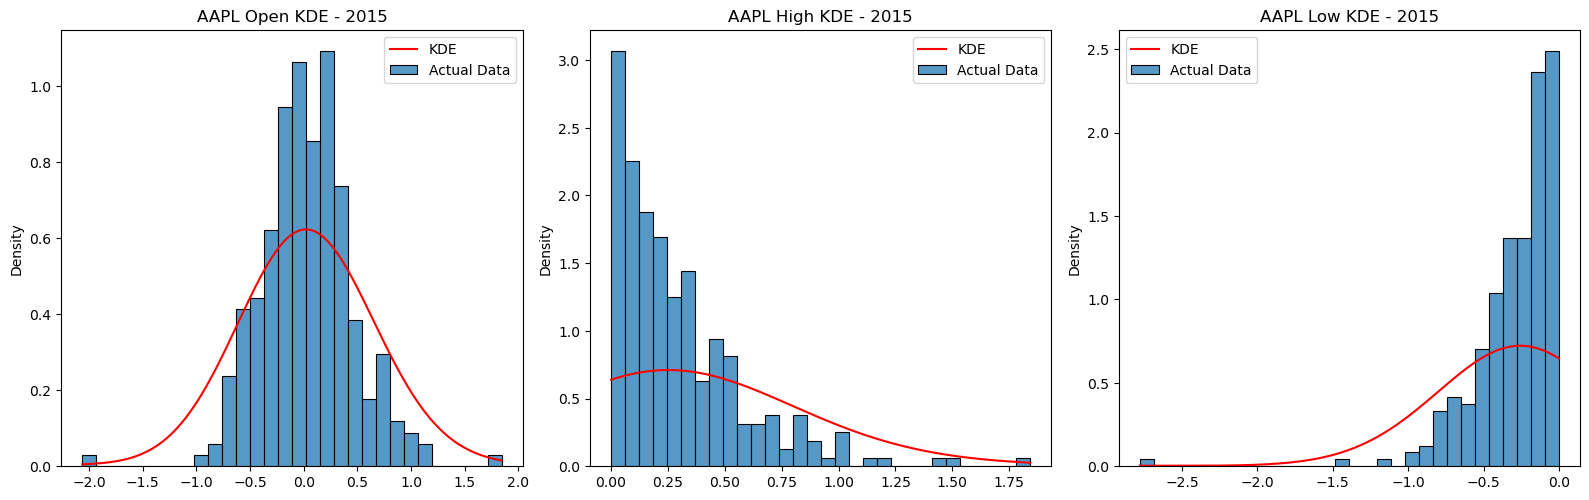

In [18]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Define the metrics
metrics = ["Open", "High", "Low"]

# Filter data for the year 2015
df_2015 = df[df["Year"] == 2015]

# Visualize KDE models for AAPL's metrics
for i, metric in enumerate(metrics):
    delta = metric.lower()
    data = df_2015[f"AAPL_{metric}"] - df_2015["AAPL_Close"]
    model = kde_models[2015][f"AAPL_delta_{delta}"]
    plot_kde_subplot(axes[i], model, data, title=f"AAPL {metric} KDE - 2015")

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

<h3> 6.0 Main simulation </h3>

Now that we have the correlated JDM model for AAPL, MSFT, AMZN, Merton JDM for VIX, Linear Factor model of SPX and finally the KDE for simulating traded volume, difference in Open, High, Low prices, we are now ready to simulate the data.

<h4> 6.1 Constants </h4>

The Code chunk below will be setting the number of simulations per year. The numbers grows at an exponential scale where $2015 \approx e^2$, $2016 \approx e^3$... $2022 \approx e^9$. Purpose of this is to generate more data for the recent years, putting more emphasis on recent market trends.

In [19]:
# N_SIMS = {2015: 7,    2016: 20,  2017: 50,
#           2018: 150,  2019: 400, 2020: 1000,
#           2021: 3000, 2022: 8000} 

N_SIMS = {2015: 2,    2016: 7,  2017: 20,
          2018: 50,  2019: 150, 2020: 400,
          2021: 1000, 2022: 3000} 

# N_SIMS = {2015: 5, 2016: 5, 2017: 5,
#           2018: 5, 2019: 5, 2020: 5,
#           2021: 5, 2022: 5} 

<h4>6.2 Simulating Closing Prices, volume and delta values</h4>

The function simulate_closing_prices uses the CorrelatedJDM model to simulate closing prices for a given year. The number of days to simulate is set to 252 by default, which represents the typical number of trading days in a year.

The function simulate_volume_and_deltas uses KDE models to simulate volume and delta values (open, high, low) for the assets. The simulated closing prices are used to calculate the open, high, and low values based on the simulated delta values.

In [20]:
def simulate_closing_prices(year, n_days=260, Corr_JDM_models = correlated_JDM_models):
    """
    Simulate closing prices for a given year using the CorrelatedJDM model.
    
    Parameters:
    - year       : The year for which the simulation is to be done.
    - n_days     : Number of days to simulate (default is 252, i.e., trading days in a year).
    - JDM_models : dictionary of correlated JDM models.
    
    Returns:
    - DataFrame of simulated closing prices.
    """
    return Corr_JDM_models[year].simulate(n_days)

def simulate_volume_and_deltas(year, simulated_closes, assets = KDE_MODEL_ASSETS):
    """
    Simulate volume and delta values (open, high, low) using KDE models.
    
    Parameters:
    - year             : The year for which the simulation is to be done.
    - simulated_closes : DataFrame of simulated closing prices.
    
    Returns:
    - DataFrame with simulated volume, open, high, and low values.
    """

    # Converting simulated_closes to a dataframe 
    df_simulated = simulated_closes.copy()

    # df_simulated = pd.DataFrame(simulated_closes, columns = list(map(lambda x: f"{x}_Close", assets)))

    for asset in assets:
        # Simulating volume
        if asset not in ["VIX", "IRX"]:
            df_simulated[f"{asset}_Volume"] = kde_models[year][asset].sample(len(df_simulated))

        # simulating specific metric
        delta_open = kde_models[year][f"{asset}_delta_open"].sample(len(df_simulated)).reshape(-1)
        delta_high = kde_models[year][f"{asset}_delta_high"].sample(len(df_simulated)).reshape(-1)
        delta_low  = kde_models[year][f"{asset}_delta_low"].sample(len(df_simulated)).reshape(-1)

        # Adding to dataframe
        df_simulated[f"{asset}_Open"] = delta_open + df_simulated[f"{asset}_Close"].values
        df_simulated[f"{asset}_High"] = delta_high + df_simulated[f"{asset}_Close"].values
        df_simulated[f"{asset}_Low"]  = delta_low + df_simulated[f"{asset}_Close"].values

        # Ensuring low is the lowest and high is the highest
        df_simulated[f"{asset}_High"] = df_simulated[[f"{asset}_Open", 
                                                      f"{asset}_High", 
                                                      f"{asset}_Low", 
                                                      f"{asset}_Close"]].max(axis=1)
        df_simulated[f"{asset}_Low"]  = df_simulated[[f"{asset}_Open", 
                                                      f"{asset}_High", 
                                                      f"{asset}_Low", 
                                                      f"{asset}_Close"]].min(axis=1)
        

    return df_simulated


<h4>6.3 Main Simulation Loop</h4>

The main simulation loop iterates through the specified years and generates N samples of data for each year. The simulated data includes closing prices, volume, and open, high, and low values for the assets.

In the generated simulated data's dataframe, there will be two columns, the year it is simulating, as well as the n'th simulation of that year. This will be crucial during the data preperation stages of training the neural network; make sure each training sample is from the same simulation.

In [22]:
N_DAYS = 260 # Days of simulation (per year)

# Initialising empty dataframe
simulated_data = pd.DataFrame()

for YEAR in N_SIMS:
    print(f"Simulating {YEAR} {N_SIMS[YEAR]} times")
    
    for N_SIM in range(0, N_SIMS[YEAR]):

        # Generating simulation samples of AAPL, MSFT and AMZN
        simulated_closes = simulate_closing_prices(YEAR, n_days=N_DAYS)
        vix_closes       = vix_models[YEAR].simulate(N_DAYS-1)
        irx_closes       = irx_models[YEAR].simulate(N_DAYS-1)

        simulated_data_temp = pd.DataFrame(np.column_stack([simulated_closes, vix_closes, irx_closes]),
                                           columns = ["AAPL_Close", "MSFT_Close", "AMZN_Close", "VIX_Close", "IRX_Close"])

        # # Implementing SPX's linear factor model with the simulated sample data
        simulated_data_temp["SPX_Close"] = lfm.predict(simulated_data_temp.values)

        # # Using KDE's to simulate and sample traded volumes, open, high, low prices.
        simulated_data_temp = simulate_volume_and_deltas(YEAR, simulated_data_temp, 
                                                         assets = ["AAPL", "MSFT", "AMZN", "SPX", "VIX", "IRX"])

        # Adding indicator of year and n'th simulation
        simulated_data_temp["Year"]  = [YEAR] * N_DAYS
        simulated_data_temp["N_Sim"] = [N_SIM] * N_DAYS

        if len(simulated_data)==0:
            simulated_data = simulated_data_temp
        else:
            simulated_data = pd.concat([simulated_data, simulated_data_temp])


Simulating 2015 2 times
Simulating 2016 7 times
Simulating 2017 20 times
Simulating 2018 50 times
Simulating 2019 150 times
Simulating 2020 400 times
Simulating 2021 1000 times
Simulating 2022 3000 times


<h4>6.4 Saving data</h4>

Now that the data has been generated, we can now save the generated data as csv.

In [ ]:
SAVE_PATH = "DATA/processed/simulated_data.csv"

save_to_csv(simulated_data, SAVE_PATH)

Data saved to DATA/processed/simulated_data.csv
